# Classificador de Gênero Musical
---

Utilizando apenas letras, classificar automaticamente músicas dentro dos gêneros 'Bossa Nova', 'Funk', 'Gospel' e 'Sertanejo'.


## Bibliotecas e configurações básicas

In [1]:
import itertools
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import string
import re

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pickle

## Carregando dados
___
Preparados previamente em analysis.ipynb

In [2]:
df = pd.read_csv('../input/dataset.csv')
df.head(10)

,lyric,genre
0,"Ah, é melhor deixar o amor em modo avião Dá ...",funk
1,Deus escreveu a tua história antes de você n...,gospel
2,"Ele era só um menino, à frente daquele gigan...",gospel
3,Lágrimas de sofrimento rolam dentro de mim P...,funk
4,"Deus enviou seu Filho amado, para morrer no ...",gospel
5,Luz das nações que dissipa as trevas Abre os...,gospel
6,Se você não me queria Não devia me procurar ...,bossa_nova
7,Quando você fica triste Desespero insiste em...,gospel
8,"Quer saber, entre a gente nunca existiu segr...",sertanejo
9,"Eu só queria te dizer, o quanto amo você Vim...",funk


## Funções básicas NLP
---
Funções e recursos como Tokenizers e stopwords (EN e pt-BR)

In [3]:
# Estruturando stop words
with open('../resources/stopwords.txt', 'r') as infile:
    stopwords = infile.read().splitlines()
# print('stop words %s ...' %stopwords[:5])

# Extrair tokens das letras
def tokenizer(text):
    source = text.lower()
    source = nltk.word_tokenize(source)
    return source
# tokens = tokenizer("Don't !!! --- want swimming. ")
# print('tokens: ' + str(tokens) )

## Preparando os dados para treinamento
---

Primeiro, para a representação do espaço dimensional, se utilizará o conceito de Bag of Words. Para tal, irá ser adotado a métrica de frequência de termos TF-IDF (conforme explicado no notebook 'analysis').<br>
Por fim, com os dados preparados, é dividio o conjunto de dados entre treinamento e teste/validação, 90% e 10% das amostras respectivamente.

In [4]:
# Term Frequency Inverse Document Freq.(TF - Normalize Vectors, IDF: Penalize Frequent Words)
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(
        encoding   = 'utf-8',
        stop_words = stopwords,
        tokenizer  = tokenizer,
        ngram_range=(1, 4) ).fit(df['lyric'].values)

X = vec.transform(df['lyric'].values) # Transforming
y = df['genre'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1,  random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#data = pd.DataFrame(y_train)
#data.groupby(0).size()

(2880, 861750) (2880,)
(320, 861750) (320,)


In [5]:
# # Salvando o vectorizer (webapp)
# with open('../resources/vectorizer.pkl', 'wb') as outfile:
#     pickle.dump(vec, outfile, pickle.HIGHEST_PROTOCOL)

In [6]:
# with open('../input/X_train.dat', 'wb') as outfile:
#     pickle.dump(X_train, outfile, pickle.HIGHEST_PROTOCOL)
# with open('../input/y_train.dat', 'wb') as outfile:
#     pickle.dump(y_train, outfile, pickle.HIGHEST_PROTOCOL)
    
# with open('../input/X_test.dat', 'wb') as outfile:
#     pickle.dump(X_test, outfile, pickle.HIGHEST_PROTOCOL)
# with open('../input/y_test.dat', 'wb') as outfile:
#     pickle.dump(y_test, outfile, pickle.HIGHEST_PROTOCOL)

## Classificador

### Naive Bayes (Multinomial)
---
Como o NB é um modelo probabilístico, este sofre com o caso de um termo não estar presente no corpus, resultando em P(g|t) = 0. Portanto, será considerado termo alpha como fator de alisamento do modelo n-grama. Em testes durante o treinamento, ajustou-se o alpha = .01, dado que tal valor mostrou-se como o mais eficiente considerando a acurácia do modelo.

In [8]:
# Classificador: NaiveBayes (Multinomial with TFid)
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=.01).fit(X_train, y_train)

In [9]:
# # Salvando o classificador (webapp)
# with open('../resources/classifier.pkl', 'wb') as outfile:
#     pickle.dump(clf, outfile, pickle.HIGHEST_PROTOCOL)

### Avaliando o classificador

Acurácia do classificador: 91.25%


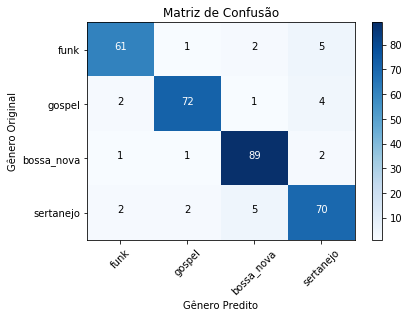

In [10]:
# Avaliacao do modelo
y_pred = clf.predict(X_test)

# Acurácia do modelo
print( 'Acurácia do classificador: %.2f%%' % (metrics.accuracy_score(y_test, y_pred)*100) )

# Matriz de confusão
cm = metrics.confusion_matrix(y_test, y_pred)
classes = list( df['genre'].unique() )
plt.imshow(cm, cmap=plt.cm.Blues, aspect='auto')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.title('Matriz de Confusão')
plt.ylabel('Gênero Original')
plt.xlabel('Gênero Predito')

## Conclusão
---
O modelo probabilístico de Naive Bayes se mostra eficiente para a resolução do problema de classificação de gênero musical baseado em letras, com uma taxa de precisão de ~90% obtido pelo classificador proposto. Conforme os testes destacaram, corroborando a liteturatura correlata, o processo de preparação e tratamento dos dados possui grande influência no resultado final do modelo.<br>
Para a evolução do trabalho, a exploração adicional da preparação do conjunto de dados pode ser mais profundamente investigado. Por exemplo, seria interessante buscar padrões sintáticos que distinguem os gêneros, ou ainda avaliar outras abordagens no processo de criação de tokens, considerando outros n-gramas ou aplicar redução do radical aos termos do conjunto de dados. Além disso, conforme destacam alguns trabalhos recentes nesta área, a adoção de novos modelos que relevem o contexto semântico das composições, tal como Word2Vec, podem colaborar para a melhor dos resultados obtidos no problema de clâssificação de gênero musical baseado em letras.

## References

* https://arxiv.org/pdf/1611.00138.pdf
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* http://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* https://www.reddit.com/r/MachineLearning/comments/2q2185/improving_naive_bayes_accuracy_for_text/
* _
* https://www.vooo.pro/insights/6-passos-faceis-para-aprender-o-algoritmo-naive-bayes-com-o-codigo-em-python/
* https://www.ppgia.pucpr.br/~paraiso/mineracaodeemocoes/recursos/emocoesENIAC2013.pdf
* _
* https://www.serasaexperian.com.br/datalabs-noticias/padroes-em-sequencias-embeddings-e-word2vec/
* _
* https://spandan-madan.github.io/DeepLearningProject/
* http://radimrehurek.com/data_science_python/

In [14]:
import watermark
%watermark -d -v -a 'Diego Luiz Cavalca' -p sklearn,numpy,pandas,nltk

ERROR:root:Line magic function `%watermark` not found.
